# Оптимизация производственных расходов металлургического комбината

**Описание проекта:**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

 -  data_arc.csv — данные об электродах;
 -  data_bulk.csv — данные о подаче сыпучих материалов (объём);
 -  data_bulk_time.csv — данные о подаче сыпучих материалов (время);
 -  data_gas.csv — данные о продувке сплава газом;
 -  data_temp.csv — результаты измерения температуры;
 -  data_wire.csv — данные о проволочных материалах (объём);
 -  data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


**План работ**

1. Исследуем и подготовим данные.
2. Обучим несколько моделей на тренировочной выборке и выберем лучшую.
3. Протестируем лучшую модель на тестовой выборке.
4. Напишем отчет.

**Цель**

Сократить расходы металлургического комбината на электроэнергию на этапе обработки стали и оптимизировать производство.

## Исследуем и подготовим данные

### Импортируем библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

from IPython.display import display

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Исследуем данные

#### Посмотрим на данные об электродах

In [3]:
try:
    data_arc = pd.read_csv('/DS/datasets/metall/data_arc_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')

In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc[['Активная мощность', 'Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


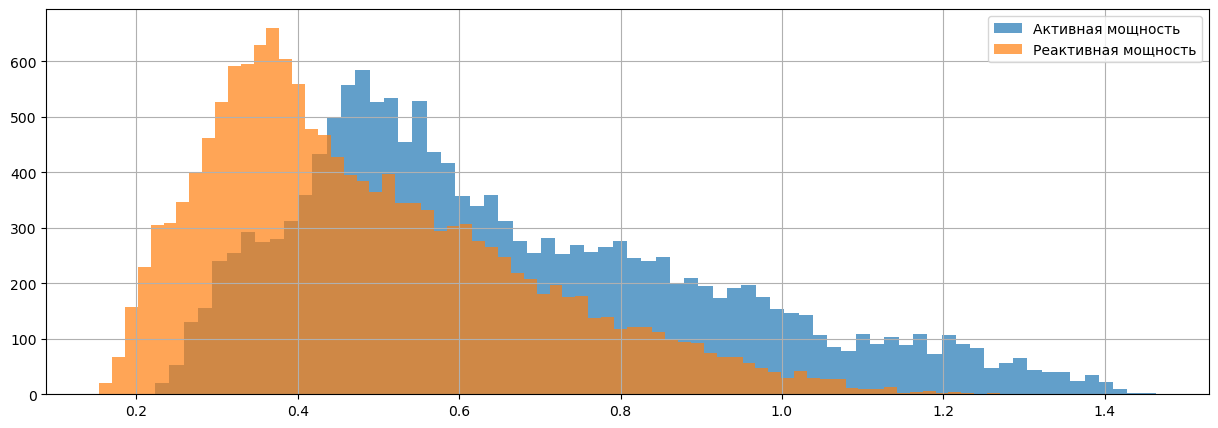

In [7]:
data_arc['Активная мощность'].hist(bins=70, figsize=(15, 5), label='Активная мощность', alpha=0.7)

data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=70, figsize=(15, 5),\
                                                                          label='Реактивная мощность', alpha=0.7)
plt.legend();

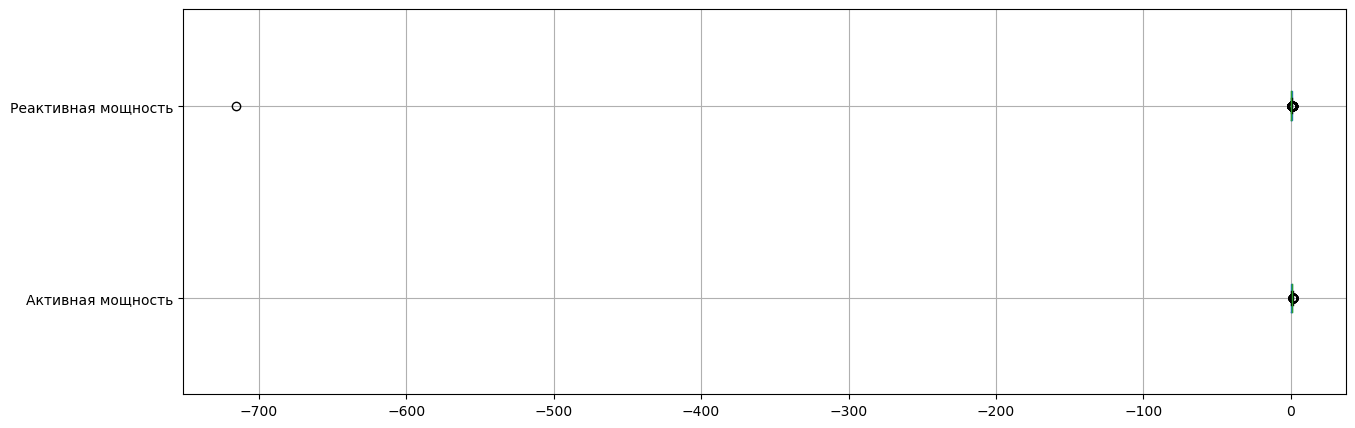

In [8]:
data_arc.drop('key', axis=1).boxplot(figsize=(15, 5), vert=False);

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** в столбце `Реактивная мощность` имеется аномальное отрицательное значение, которое следует удалтить. Пропусков в данных нет. Тип данных в столбцах `Начало нагрева дугой` и `Конец нагрева дугой` нужно изменить с `object` на `datetime`.

#### Посмотрим на данные о подаче сыпучих материалов (объём)

In [9]:
try:
    data_bulk = pd.read_csv('/DS/datasets/metall/data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

In [10]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


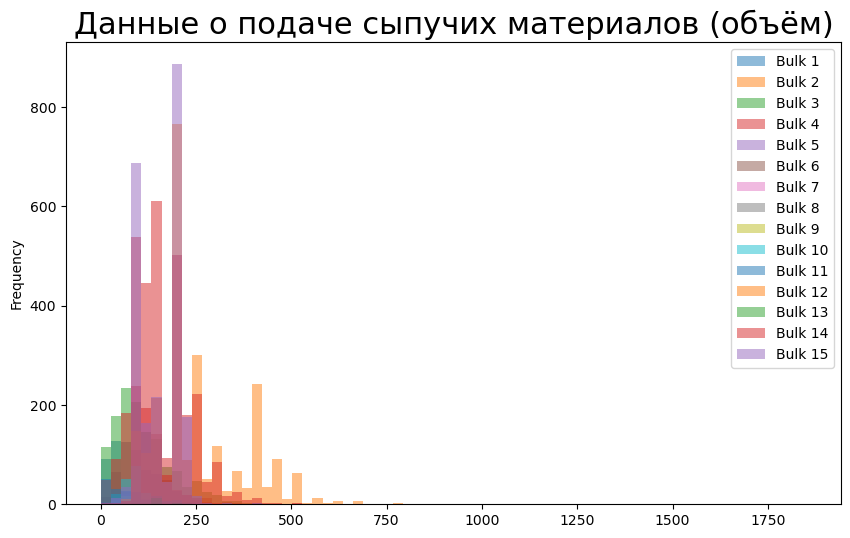

In [12]:
data_bulk.drop('key', axis=1).plot(kind='hist', bins=70, figsize=(10,6), alpha=0.5)

plt.title('Данные о подаче сыпучих материалов (объём)', fontsize=22);

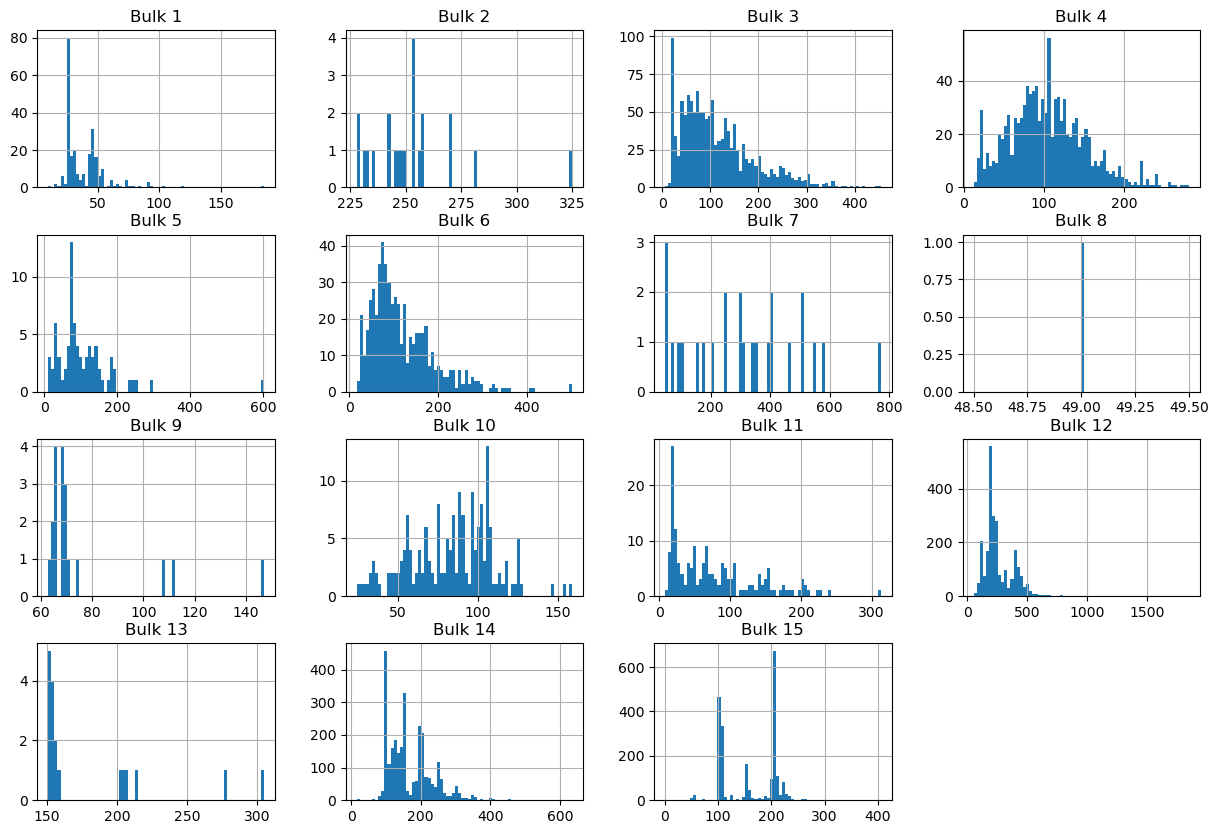

In [13]:
data_bulk.drop('key', axis=1).hist(bins=70, figsize=(15,10));

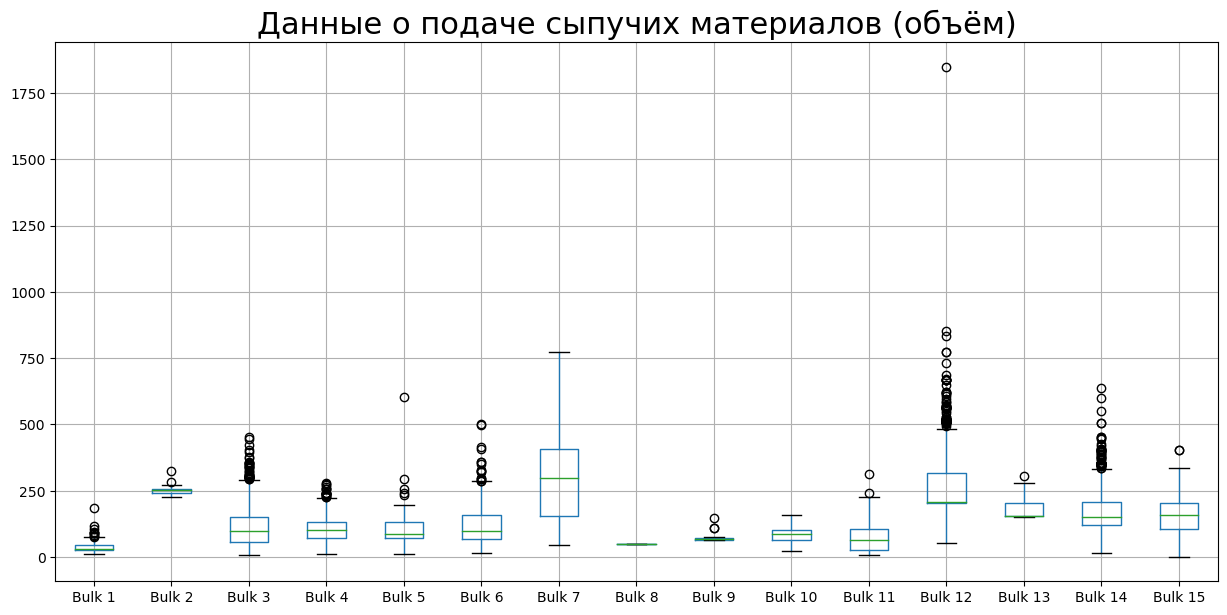

In [14]:
data_bulk.drop('key', axis=1).boxplot(figsize=(15,7))

plt.title('Данные о подаче сыпучих материалов (объём)', fontsize=22);

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** в данных очень много пропусков, есть практически пустые столбцы, следует запросить у заказчика более полные данные, т.к. они могли утеряться при записи файла. Если данны не были учтены, тогда для обучения модели подойдут лишь 3и столбца, в которых наименьшее количество пропусков, и заполнить пропуски нулями. Поменять тип данных с `float64` на `int64`, т.к. в данных содержатся целые числа. Так же видим выбросы в некоторых столбцах, которые будем удалять.

#### Посмотрим на данные о подаче сыпучих материалов (время)

In [15]:
try:
    data_bulk_time = pd.read_csv('/DS/datasets/metall/data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

In [16]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [17]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** изменить тип данных в столбцах с `object` на `datetime`.

#### Посмотрим на данные о продувке сплава газом

In [18]:
try:
    data_gas = pd.read_csv('/DS/datasets/metall/data_gas_new.csv')
except:
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')

In [19]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [20]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

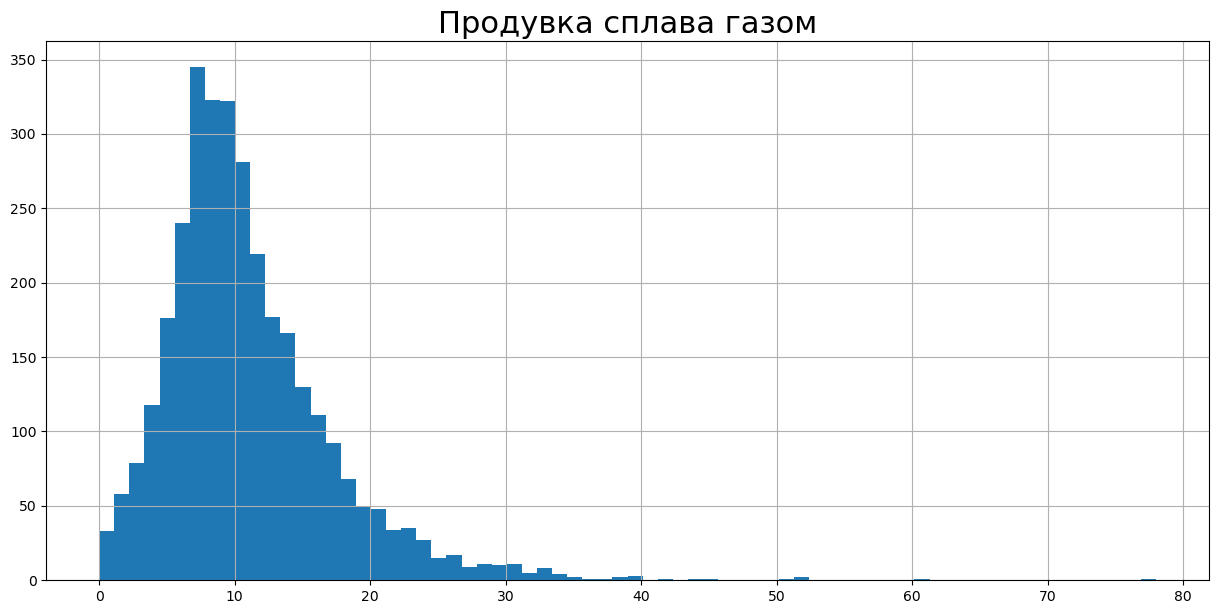

In [22]:
data_gas['Газ 1'].hist(bins=70, figsize=(15, 7))

plt.title('Продувка сплава газом', fontsize=22);

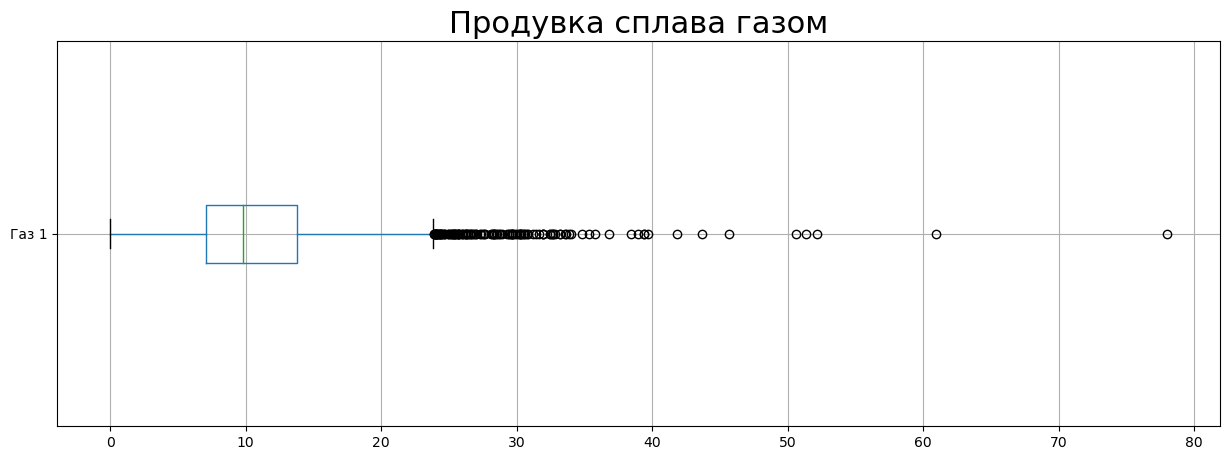

In [23]:
data_gas.boxplot(column='Газ 1', figsize=(15,5), vert=False)

plt.title('Продувка сплава газом', fontsize=22);

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** данные полные. Но есть выбросы. После общения с заказчиком, когда будет больше информации о технологическом  процессе, примем решение, удалить или оставить.

#### Посмотрим на результаты измерения температуры

In [24]:
try:
    data_temp = pd.read_csv('/DS/datasets/metall/data_temp_new.csv')
except:
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')

In [25]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [27]:
data_temp.Температура.describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

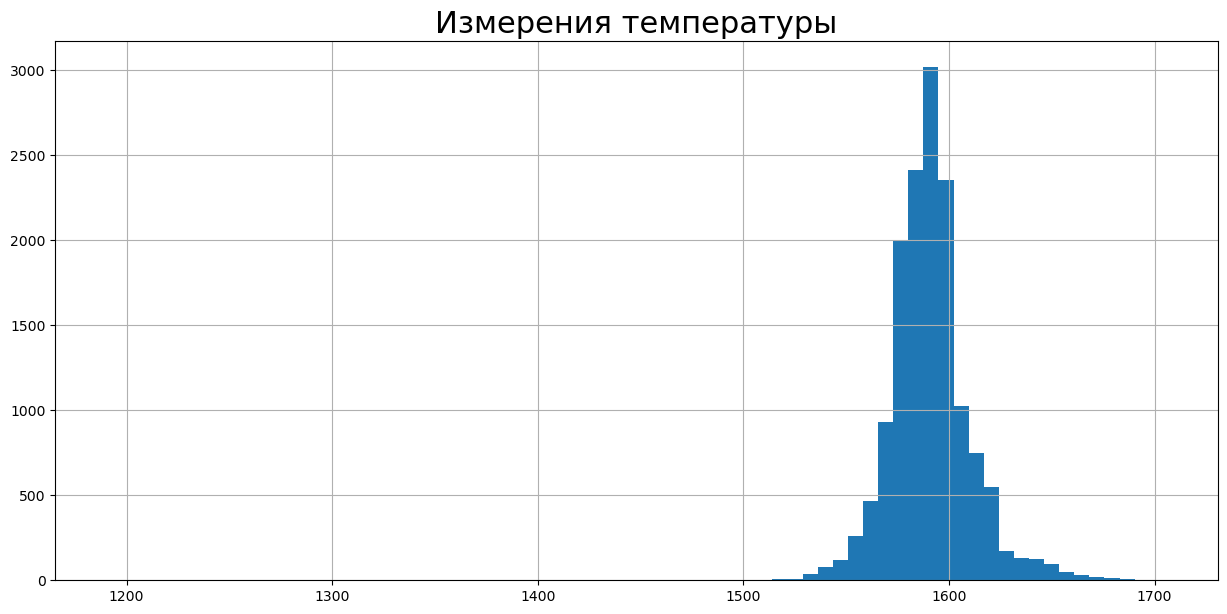

In [28]:
data_temp.Температура.hist(bins=70, figsize=(15, 7))

plt.title('Измерения температуры', fontsize=22);

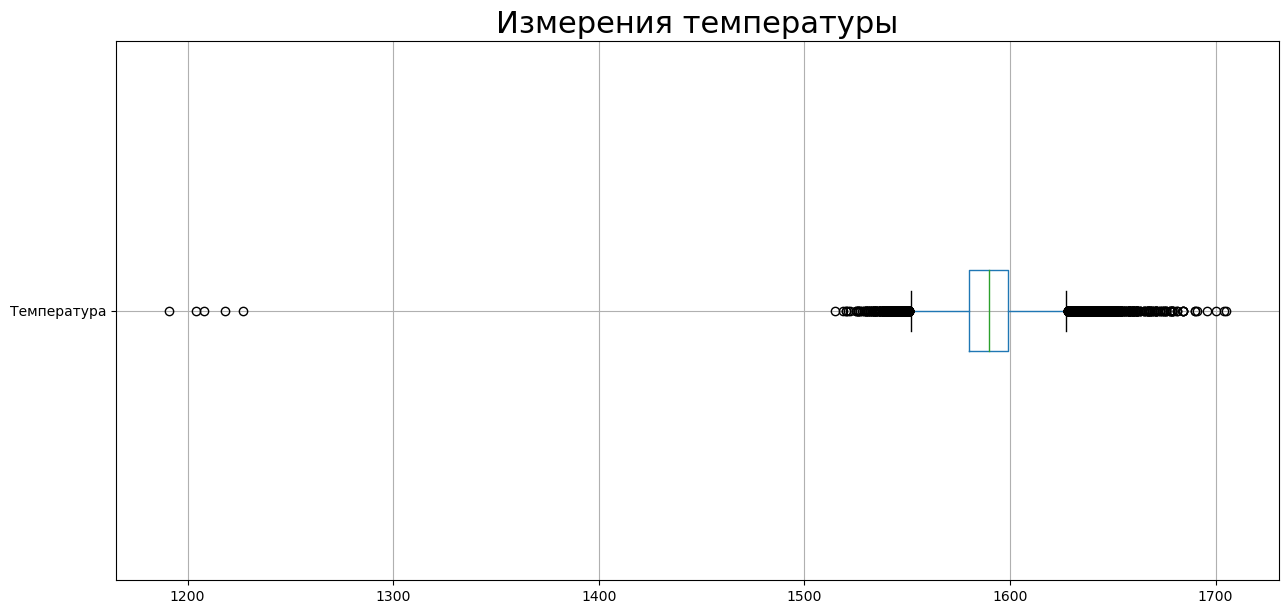

In [29]:
data_temp.boxplot(column='Температура', figsize=(15, 7), vert=False)

plt.title('Измерения температуры', fontsize=22);

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** в измерениях температуры имеются пропуски, нужно уточнить у заказчика, полные дынные, т.к. могла произойти потеря или забыли записать в файл. Если полные данные получить не удастся, то следует заполнить пропуски предыдущими измерениями. Видим, что в данных есть выбросы, которые следует удалить. В столбце `Температура` изменить тип данных с float64 на int64, данные содержат целые числа, а в столбце `Время замера` изменить тип данных с object на datetime.

#### Посмотрим на данные о проволочных материалах (объём)

In [30]:
try:
    data_wire = pd.read_csv('/DS/datasets/metall/data_wire_new.csv')
except:
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')

In [31]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


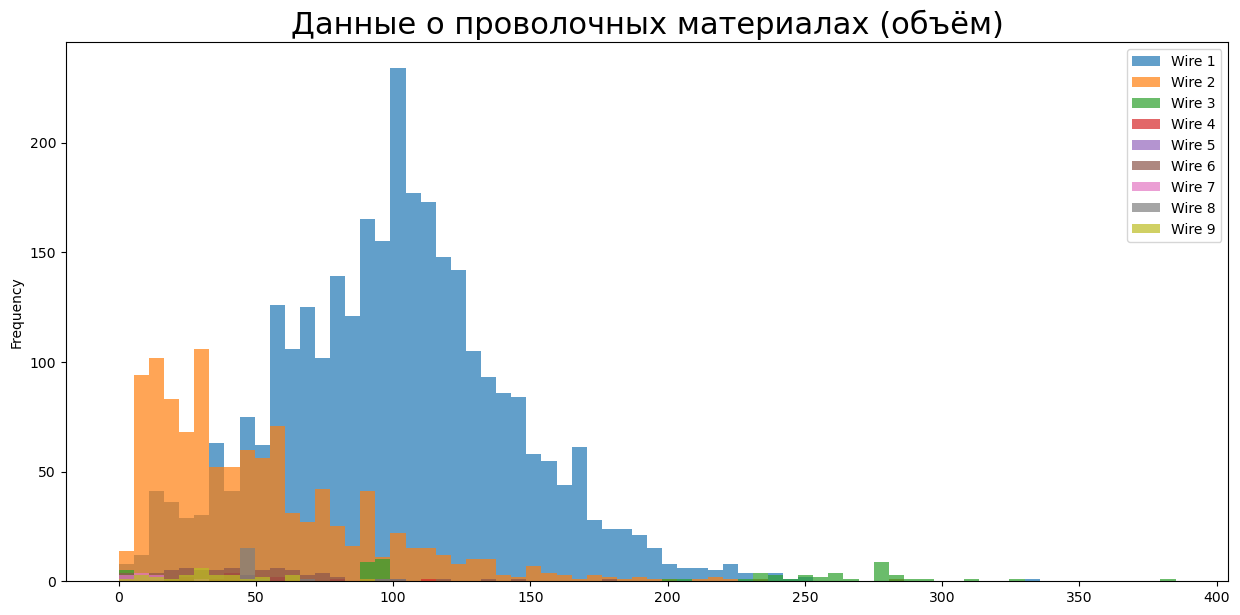

In [33]:
data_wire.drop('key', axis=1).plot(kind='hist', bins=70, figsize=(15,7), alpha=0.7)

plt.title('Данные о проволочных материалах (объём)', fontsize=22);

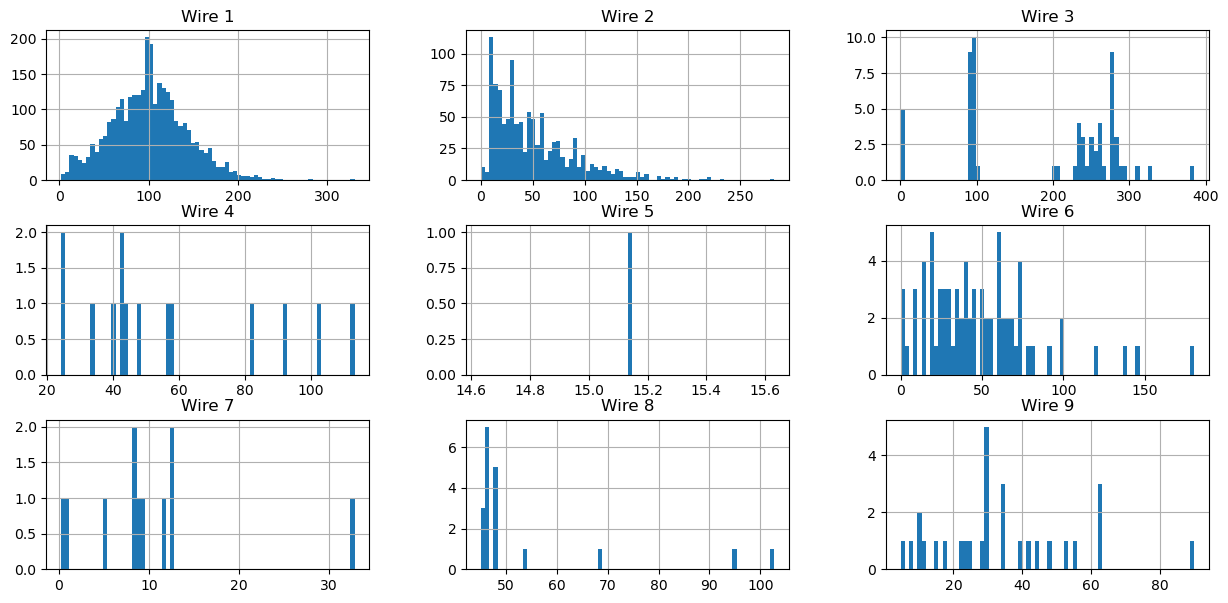

In [34]:
data_wire.drop('key', axis=1).hist(bins=70, figsize=(15,7));

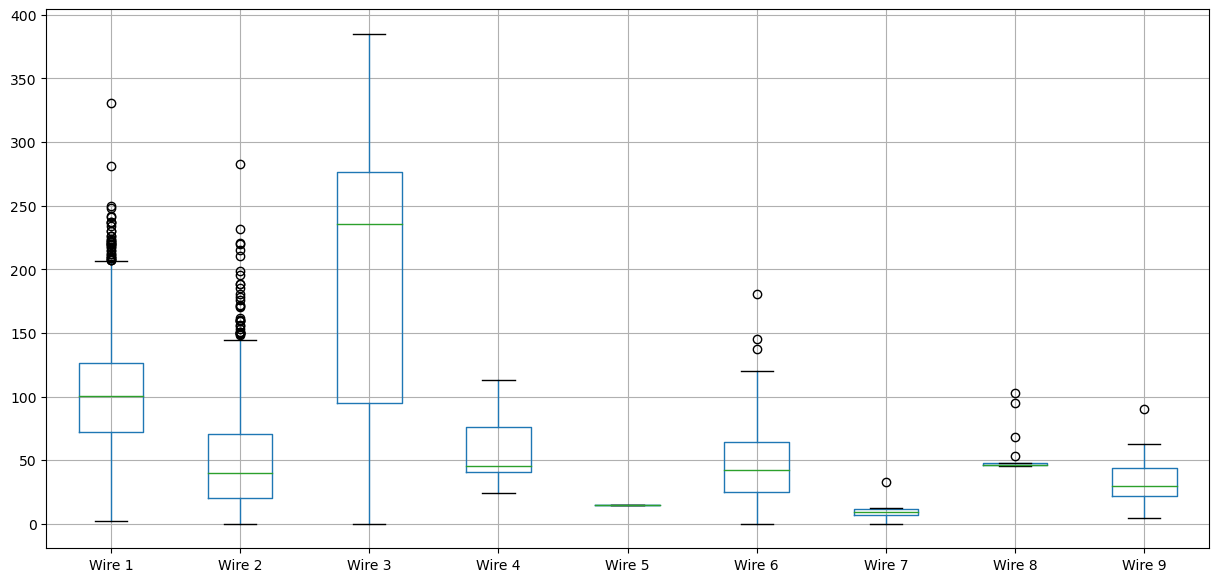

In [35]:
data_wire.drop('key', axis=1).boxplot(figsize=(15,7));

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** аналогично как и в `Данных о подаче сыпучих материалов (объём)` очень много пропусков, есть практически пустые столбцы, следует запросить у заказчика более полные данные, т.к. они могли утеряться при записи файла. Если данны не были учтены, тогда для обучения модели подойдут лишь 3и столбца, в которых наименьшее количество пропусков, и заполнить пропуски нулями. Wire1 и wire2 содержат несколько анамалий, которые мы удалим.

#### Посмотрим на данные о проволочных материалах (время)

In [36]:
try:
    data_wire_time = pd.read_csv('/DS/datasets/metall/data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [37]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** изменить тип данных в столбцах с `object` на `datetime`.

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** 

- В данных об электродах пропусков нет. В столбце `Реактивная мощность` есть измерения с отрицательным значением, скорее всего это выбросы.
- В данные о подаче сыпучих материалов очень много пропусков, в большинстве столбцах можно сказать они вообще отсутствуют.
- В данных о продувке сплава газом пропусков нет.
- В результах измерения температуры потеря данных, т.к. во `Времени замеров` нет пропусков, а в `Температуре` имеются.
- В данные о проволочных материалах так же, как и в данных о подаче сыпучих материалов множество пропусков.

Уточняющие вопросы к `Заказчику`:

1. Хорошо было бы получить больше информации по технологическому процессу - это даст больше понимания для достижения максимально наилучшего результата оптимизации расходов. 
2. Что означают столбцы `Bulk` в подаче сыпучих материалов? С чем может быть связано практическое отсутствие данных в этом файле? Потеря или не было учета?
3. Что означают столбцы `Wire` в данных о проволочных материалах? Так же отсутсвие данных как и в `подаче сыпучих материалах`, вопрос тот же, с чем может быть связано?
4. В результатах измерения температуры во `Времени замеров` нет пробелов, а вот в `Температуре` есть, возможно потеря данных при записи файла, можете ли вы предоставить полные данные?

### Подготовим данные, удалим аномалии и обработаем пропуски

#### Подготовим данные об электродах

In [39]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0 ].reset_index(drop=True)

In [40]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [41]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14875 entries, 0 to 14874
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [42]:
data_arc.duplicated().sum()

0

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** удалили аномалию в столбце `Реактивная мощность`. Изменили тип данных в столбцах `Начало нагрева дугой` и `Конец нагрева дугой` с `object` на `datetime`. Проверили данные на явные дубликаты - отсутствуют.

#### Подготовим данные по подаче сыпучих материалов (объём)

In [43]:
data_bulk = data_bulk.fillna(0)

In [45]:
data_bulk = data_bulk.astype(int)

In [46]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   Bulk 1   3129 non-null   int64
 2   Bulk 2   3129 non-null   int64
 3   Bulk 3   3129 non-null   int64
 4   Bulk 4   3129 non-null   int64
 5   Bulk 5   3129 non-null   int64
 6   Bulk 6   3129 non-null   int64
 7   Bulk 7   3129 non-null   int64
 8   Bulk 8   3129 non-null   int64
 9   Bulk 9   3129 non-null   int64
 10  Bulk 10  3129 non-null   int64
 11  Bulk 11  3129 non-null   int64
 12  Bulk 12  3129 non-null   int64
 13  Bulk 13  3129 non-null   int64
 14  Bulk 14  3129 non-null   int64
 15  Bulk 15  3129 non-null   int64
dtypes: int64(16)
memory usage: 391.2 KB


In [47]:
data_bulk.duplicated().sum()

0

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** удалили пару выбросов. После небольшого углубления в технологический процесс стало понятно, где есть пропуски, значит присадки не добавлялись, их заполнили нолями. Изменили тип данных в столбцах с `float64` на `int64`.

#### Подготовим результаты измерения температуры¶


In [48]:
data_temp = data_temp.query('(Температура > 1450) | (Температура.isna())').reset_index(drop=True)

In [49]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [50]:
data_temp = data_temp.fillna(0)

In [51]:
data_temp.tail(50)

,key,Время замера,Температура
18037,3232,2019-09-06 08:45:13,0.0
18038,3232,2019-09-06 08:51:15,0.0
18039,3232,2019-09-06 08:56:50,0.0
18040,3232,2019-09-06 09:00:52,0.0
18041,3233,2019-09-06 09:15:00,1597.0
18042,3233,2019-09-06 09:21:31,0.0
18043,3233,2019-09-06 09:33:07,0.0
18044,3233,2019-09-06 09:40:13,0.0
18045,3234,2019-09-06 09:41:13,1614.0
18046,3234,2019-09-06 09:47:54,0.0


In [52]:
data_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [53]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18087 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18087 non-null  int64         
 1   Время замера  18087 non-null  datetime64[ns]
 2   Температура   18087 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.0 KB


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** удалили аномалии, изменили тип данных в столбце `Время замера` с object на datetime. Пропуски обработаем после подготовления целевого признака. На данном этапе удалить их нельзя, т.к. время измерения нам понадобится.

#### Подготовим данные о проволочных материалах (объём)

In [54]:
data_wire = data_wire.fillna(0)

In [55]:
data_wire.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** как и в данных о подаче сыпучих материалов (объём), заполняем пропуски нолями.

## Обучение и тестирование моделей

### Подготовим признаки для обучения моделей

#### Подготовим признаки об электродах

In [56]:
data_arc['Полная мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** .5

data_arc['Время нагрева дугой'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).\
apply(pd.Timedelta.total_seconds).astype('int')

data_arc['Затраченная энергия'] = data_arc['Полная мощность'] * data_arc['Время нагрева дугой']

In [57]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Затраченная энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252


In [58]:
data_arc_sum = data_arc.groupby('key')[['Время нагрева дугой', 'Полная мощность', 'Затраченная энергия']].sum()\
.reset_index()

In [59]:
data_arc_sum.head(5)

,key,Время нагрева дугой,Полная мощность,Затраченная энергия
0,1,1098,3.718736,770.282114
1,2,811,2.588349,481.760005
2,3,655,5.019223,722.837668
3,4,741,3.400038,683.455597
4,5,869,2.816980,512.169934


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** в переменной `data_arc` создали новые столбцы: `Полная мощность`, `Время нагрева дугой`, `Затраченная энергия`. Где посчитали для каждой операции в каждом ковше: время нагрева, затраченную энергию и полную мощность.
    
Создали переменную `data_arc_sum` с сумарными затратами `энергии`, `временем нагрева` и `потраченной энергией` на каждый ковш.

In [60]:
data_arc_sum

,key,Время нагрева дугой,Полная мощность,Затраченная энергия
0,1,1098,3.718736,770.282114
1,2,811,2.588349,481.760005
2,3,655,5.019223,722.837668
3,4,741,3.400038,683.455597
4,5,869,2.816980,512.169934
...,...,...,...,...
3209,3237,909,3.250657,630.503534
3210,3238,546,1.723937,286.052252
3211,3239,1216,6.014480,941.538764
3212,3240,839,4.082920,657.439848


#### Подготовим признаки по подаче сыпучих материалов (объём)

In [61]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0,0,170,0,0,0,0,0,0,0,0,252,0,130,206
3125,3238,0,0,126,0,0,0,0,0,0,0,0,254,0,108,106
3126,3239,0,0,0,0,0,114,0,0,0,0,0,158,0,270,88
3127,3240,0,0,0,0,0,26,0,0,0,0,0,0,0,192,54


In [62]:
data_bulk_1 = data_bulk[['key', 'Bulk 12', 'Bulk 14', 'Bulk 15']]

In [63]:
data_bulk_1

,key,Bulk 12,Bulk 14,Bulk 15
0,1,206,150,154
1,2,206,149,154
2,3,205,152,153
3,4,207,153,154
4,5,203,151,152
...,...,...,...,...
3124,3237,252,130,206
3125,3238,254,108,106
3126,3239,158,270,88
3127,3240,0,192,54


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** взяли столбцы где наименьшее кол-во пропусков в данных о добавке в сплав `сыпучих материалов`, возможно для улучшения модели остальные столбцы понадобится суммировать.

#### Подготовим данные о проволочных материалах (объём)

In [64]:
data_wire_1 = data_wire[['key', 'Wire 1', 'Wire 2']].reset_index(drop=True)

In [65]:
data_wire_1

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** так же как и с `сыпучими материалами` взяли наиболее информативные столбцы. В остальных очень мизерное количество данных, даже их сумирование нам не поможет, т.к. эти данные могут попасть, например, только в тренировочную выборку.

#### Подготовим признаки по температуре

In [66]:
temp_first_last = data_temp.groupby('key').agg(time_first = ('Время замера', 'first'),
                                               temp_first = ('Температура', 'first'),
                                                time_last = ('Время замера', 'last'),
                                                temp_last = ('Температура', 'last')).reset_index()

In [67]:
temp_first_last

,key,time_first,temp_first,time_last,temp_last
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,0.0
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,0.0
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,0.0
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,0.0


In [68]:
temp_first_last.columns = ['key', 'Время замера на входе', 'Температура на входе',
                'Время замера на розливе', 'Температура на розливе']

In [69]:
temp_first_last.head()

,key,Время замера на входе,Температура на входе,Время замера на розливе,Температура на розливе
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [70]:
temp_first_last[temp_first_last['Температура на розливе'] == 0]['Температура на розливе'].count() 

739

In [71]:
temp_first_last[temp_first_last['Температура на входе'] == temp_first_last['Температура на розливе']]\
                                                                                            ['key'].count()

46

In [72]:
temp_first_last.shape[0]

3216

In [73]:
temp_first_last = temp_first_last[temp_first_last['Температура на розливе'] != 0]

In [74]:
temp_first_last.shape[0]

2477

In [76]:
temp_first_last

,key,Время замера на входе,Температура на входе,Время замера на розливе,Температура на розливе
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2473,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2474,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0
2475,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0


In [77]:
temp_first_last.shape[0]

2477

In [78]:
temp_first_last_1 = temp_first_last[['key', 'Температура на входе', 'Температура на розливе']]

In [79]:
temp_first_last_1

,key,Температура на входе,Температура на розливе
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** для `признаков` взяли начальную температуру сплава при поступлении его в ковш, а для `целевого признака` температуру при розливе металла.

#### Объединим признаки

In [80]:
features = data_arc_sum.merge(data_bulk_1, on='key', how='inner')
features = features.merge(data_gas, on='key', how='inner')
features = features.merge(data_wire_1, on='key', how='inner')
features = features.merge(temp_first_last_1, on='key', how='inner')

In [81]:
features

,key,Время нагрева дугой,Полная мощность,Затраченная энергия,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Температура на входе,Температура на розливе
0,1,1098,3.718736,770.282114,206,150,154,29.749986,60.059998,0.00000,1571.0,1613.0
1,2,811,2.588349,481.760005,206,149,154,12.555561,96.052315,0.00000,1581.0,1602.0
2,3,655,5.019223,722.837668,205,152,153,28.554793,91.160157,0.00000,1596.0,1599.0
3,4,741,3.400038,683.455597,207,153,154,18.841219,89.063515,0.00000,1601.0,1625.0
4,5,869,2.816980,512.169934,203,151,152,5.413692,89.238236,9.11456,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,723,3.868721,694.177326,256,129,223,7.125735,89.150879,0.00000,1570.0,1591.0
2325,2496,940,5.070316,815.818538,256,129,226,9.412616,114.179527,0.00000,1554.0,1591.0
2326,2497,569,4.360918,823.020520,230,124,226,6.271699,94.086723,9.04800,1571.0,1589.0
2327,2498,750,3.909917,581.810739,206,129,207,14.953657,118.110717,0.00000,1591.0,1594.0


In [82]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2329 non-null   int64  
 1   Время нагрева дугой     2329 non-null   int64  
 2   Полная мощность         2329 non-null   float64
 3   Затраченная энергия     2329 non-null   float64
 4   Bulk 12                 2329 non-null   int64  
 5   Bulk 14                 2329 non-null   int64  
 6   Bulk 15                 2329 non-null   int64  
 7   Газ 1                   2329 non-null   float64
 8   Wire 1                  2329 non-null   float64
 9   Wire 2                  2329 non-null   float64
 10  Температура на входе    2329 non-null   float64
 11  Температура на розливе  2329 non-null   float64
dtypes: float64(7), int64(5)
memory usage: 218.5 KB


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** объединили признаки в одну переменную.

### Обучение моделей

#### Разделим данные на тренировочную и тестовую выборки

In [83]:
RANDOM_STATE = 110923

data_train, data_test = train_test_split(features, test_size=.25, random_state=RANDOM_STATE)

data_train.shape, data_test.shape

((1746, 12), (583, 12))

In [84]:
features_train = data_train.drop(['key', 'Температура на розливе'], axis=1)
target_train = data_train['Температура на розливе']

features_test = data_test.drop(['key', 'Температура на розливе'], axis=1)
target_test = data_test['Температура на розливе']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(1746, 10) (1746,)
(583, 10) (583,)


<div style="border:solid green 2px; padding: 20px">

**Коментарии:** разделили данные на выборки, удалили из признаков столбец `key`.

#### Обучим модель линейной регрессии и проверим метрикой MAE

In [85]:
model_lr = LinearRegression().fit(features_train, target_train)

In [86]:
scores = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_absolute_error')

final_score = pd.Series(scores).mean()

In [87]:
f'MAE линейной регрессии: {final_score * -1}'

'MAE линейной регрессии: 6.54598592252214'

#### Обучим модель случайный лес и проверим метрикой MAE

In [88]:
%%time

param_grid = {'n_estimators': range(10, 101, 10),
              'max_depth': range(1, 21)}

les_model = RandomForestRegressor(random_state=RANDOM_STATE)
search_les = RandomizedSearchCV(les_model, param_grid, n_jobs=-1, scoring='neg_mean_absolute_error')
search_les.fit(features_train, target_train)

CPU times: user 1.25 s, sys: 168 ms, total: 1.42 s
Wall time: 23 s


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=110923),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 21),
                                        'n_estimators': range(10, 101, 10)},
                   scoring='neg_mean_absolute_error')

In [89]:
search_les.best_estimator_

RandomForestRegressor(max_depth=9, n_estimators=90, random_state=110923)

In [90]:
f'MAE модели случайный лес: {search_les.best_score_ * -1}'

'MAE модели случайный лес: 6.536611231925747'

#### Обучим модель LGBMRegressor и проверим метрикой MAE

In [91]:
param_grid = {'n_estimators': range(100, 1000, 100),
        'max_depth': range(1, 6)}

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
search_lgbm = RandomizedSearchCV(model_lgbm, param_grid, n_jobs=-1, scoring='neg_mean_absolute_error')
search_lgbm.fit(features_train, target_train)

RandomizedSearchCV(estimator=LGBMRegressor(random_state=110923), n_jobs=-1,
                   param_distributions={'max_depth': range(1, 6),
                                        'n_estimators': range(100, 1000, 100)},
                   scoring='neg_mean_absolute_error')

In [92]:
search_lgbm.best_estimator_

LGBMRegressor(max_depth=3, random_state=110923)

In [93]:
search_lgbm.best_score_ * -1

6.5450930862032255

In [94]:
f'MAE модели LGBMRegressor: {search_lgbm.best_score_ * -1}'

'MAE модели LGBMRegressor: 6.5450930862032255'

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** обучив и протестировав 3и модели, лучшей получили модель случайный лес с метрикой MAE = 6.536611231925747. Протестируем лучшую модель на `тестовой выборке`.

### Тестирование лучшей модели на тестовой выборке

In [95]:
pred = search_les.predict(features_test)

mae = mean_absolute_error(target_test, pred)

In [96]:
f'Метрика MAE лучшей модели случайный лес на тестовой выборке: {mae}'

'Метрика MAE лучшей модели случайный лес на тестовой выборке: 6.476557049634525'

<div style="border:solid green 2px; padding: 20px">

**Коментарии:** получили метрику MAE лучшей модели случайный лес на тестовой выборке ниже порогового значения.

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


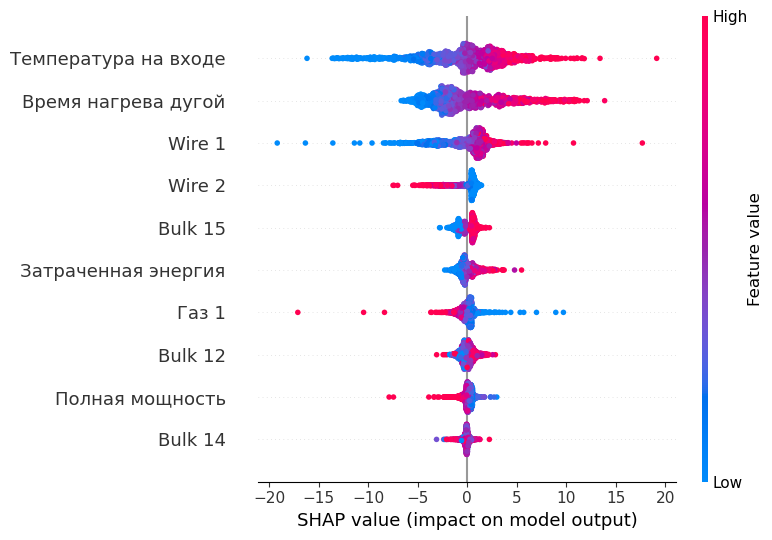

In [97]:
shap_test = shap.TreeExplainer(search_les.best_estimator_).shap_values(features_train)
shap.summary_plot(shap_test, features_train, max_display=25, auto_size_plot=True)

## Отчёт

1. Все пункты плана были выполнены.
2. Особых трудностей не возникло! Только проблема в недостатке данных по конечной температуре (целевой призна), в `подаче сыпучих материалов` и подаче `проволочных материалах`, работали с тем, что имели!
3. Ключевые шаги:
   - Исследование и предобработка данных.
   - Подготовка признаков, создание новых признаков и объеденение их всех вместе.
   - Выявление лучшей модели.
4. Итоговая модель `Случайный лес` с метрикой MAE на тестовой выборке 6.476557049634525.

- Признаки:
  - Из данных о подаче сыпучих и проволочных метериалах взяли столбцы с наиболее полными данными. Из сыпучих: Bulk 12, Bulk 14 и Bulk 15, из проволочных: Wire 1 и Wire 2.
  - Количество затраченного газа на продувку ковша.
  - Температуру заливки метала в ковш.
  - Создали новые признаки: `Время нагрева дугой`, `Полную мощность` и `Затраченная энергия`.
  - В качестве `Целевого признака` использовали `температуру розлива металла`.
  
  
- Гиперпараметры лучше модели: кол-во деревьев 90 при глубине 9, RANDOM_STATE = 110923


- Для улучшения модели можно порекомендовать несколько вариантов:
  1. Использовать более полные данные, т.е. больше наблюдений.
  2. Можно суммировать столбцы в данных о сыпучих материалах и их кол-во, т.е. проссумировать сыпучие материалы в тех столбцах, которые мы не использовали и добавить как дополнительные  признаки. Как вариант проссумировать все столбцы и посчитать их кол-во.
  3. В данных о проволочных материалах можно проссумировать все столбцы и посчитать их кол-во.
  4. Попробовать масштабировать признаки.
  5. Убрать из признаков те, которые мало влияют на обучение модели.